### Preprocessing

In [11]:
import numpy as np
import pandas as pd
import glob
import os

from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
import nltk

#nltk.download('stopwords')
#from sklearn.feature_extraction.text import CountVectorizer

import re

from sklearn.decomposition import LatentDirichletAllocation as lda
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import sys
sys.setrecursionlimit(10**5)

%run '/Users/Hugo/Documents/Github/HOTT_NLP_ENSAE/data.py'
#%run '/Users/Hugo/Documents/Github/HOTT_NLP_ENSAE/archives/data.py'
%run '/Users/Hugo/Documents/Github/HOTT_NLP_ENSAE/distances.py'
%run '/Users/Hugo/Documents/Github/HOTT_NLP_ENSAE/hott.py'
%run '/Users/Hugo/Documents/Github/HOTT_NLP_ENSAE/knn_classifier.py'

#### On load le dataframe sur lequel on travaille (ici on prend un tout petit subsample)

In [3]:
embed_path_300 = '/Users/Hugo/Documents/Cours/ENSAE/3A/S2/NLP/Projet/data/glove.6B/glove.6B.300d.txt'
#data_path_ = '/Users/Hugo/Documents/Cours/ENSAE/3A/S2/NLP/Projet/data/nyt-comments/CommentsApril2018.csv'
data_path = '/Users/Hugo/Documents/Github/HOTT_NLP_ENSAE/dataset/reduced_dataframe.csv'

df = pd.read_csv(data_path, encoding = 'latin')
#df = pd.read_csv(data_path)
#df = pd.read_csv('https://raw.githubusercontent.com/hugothimonier/HOTT_NLP_ENSAE/master/dataset/reduced_dataset_april2018.csv?token=AK6QDZMDA5JWTSMRQXHYBT26Q5SI6', encoding = 'latin1')

In [4]:
unique, counts = np.unique(df['newDesk'], return_counts = True)
print('There are %s categories in the dataset to predict.'%(len(unique)),
      '\nThe average number of document belonging to the different categories is %s.'%(np.round(np.mean(counts),0),),
      '\nThe maximum is %s and the minimum is %s.'%( np.max(counts), np.min(counts)))

There are 31 categories in the dataset to predict. 
The average number of document belonging to the different categories is 203.0. 
The maximum is 220 and the minimum is 153.


#### Heuristics on the documents before stemming

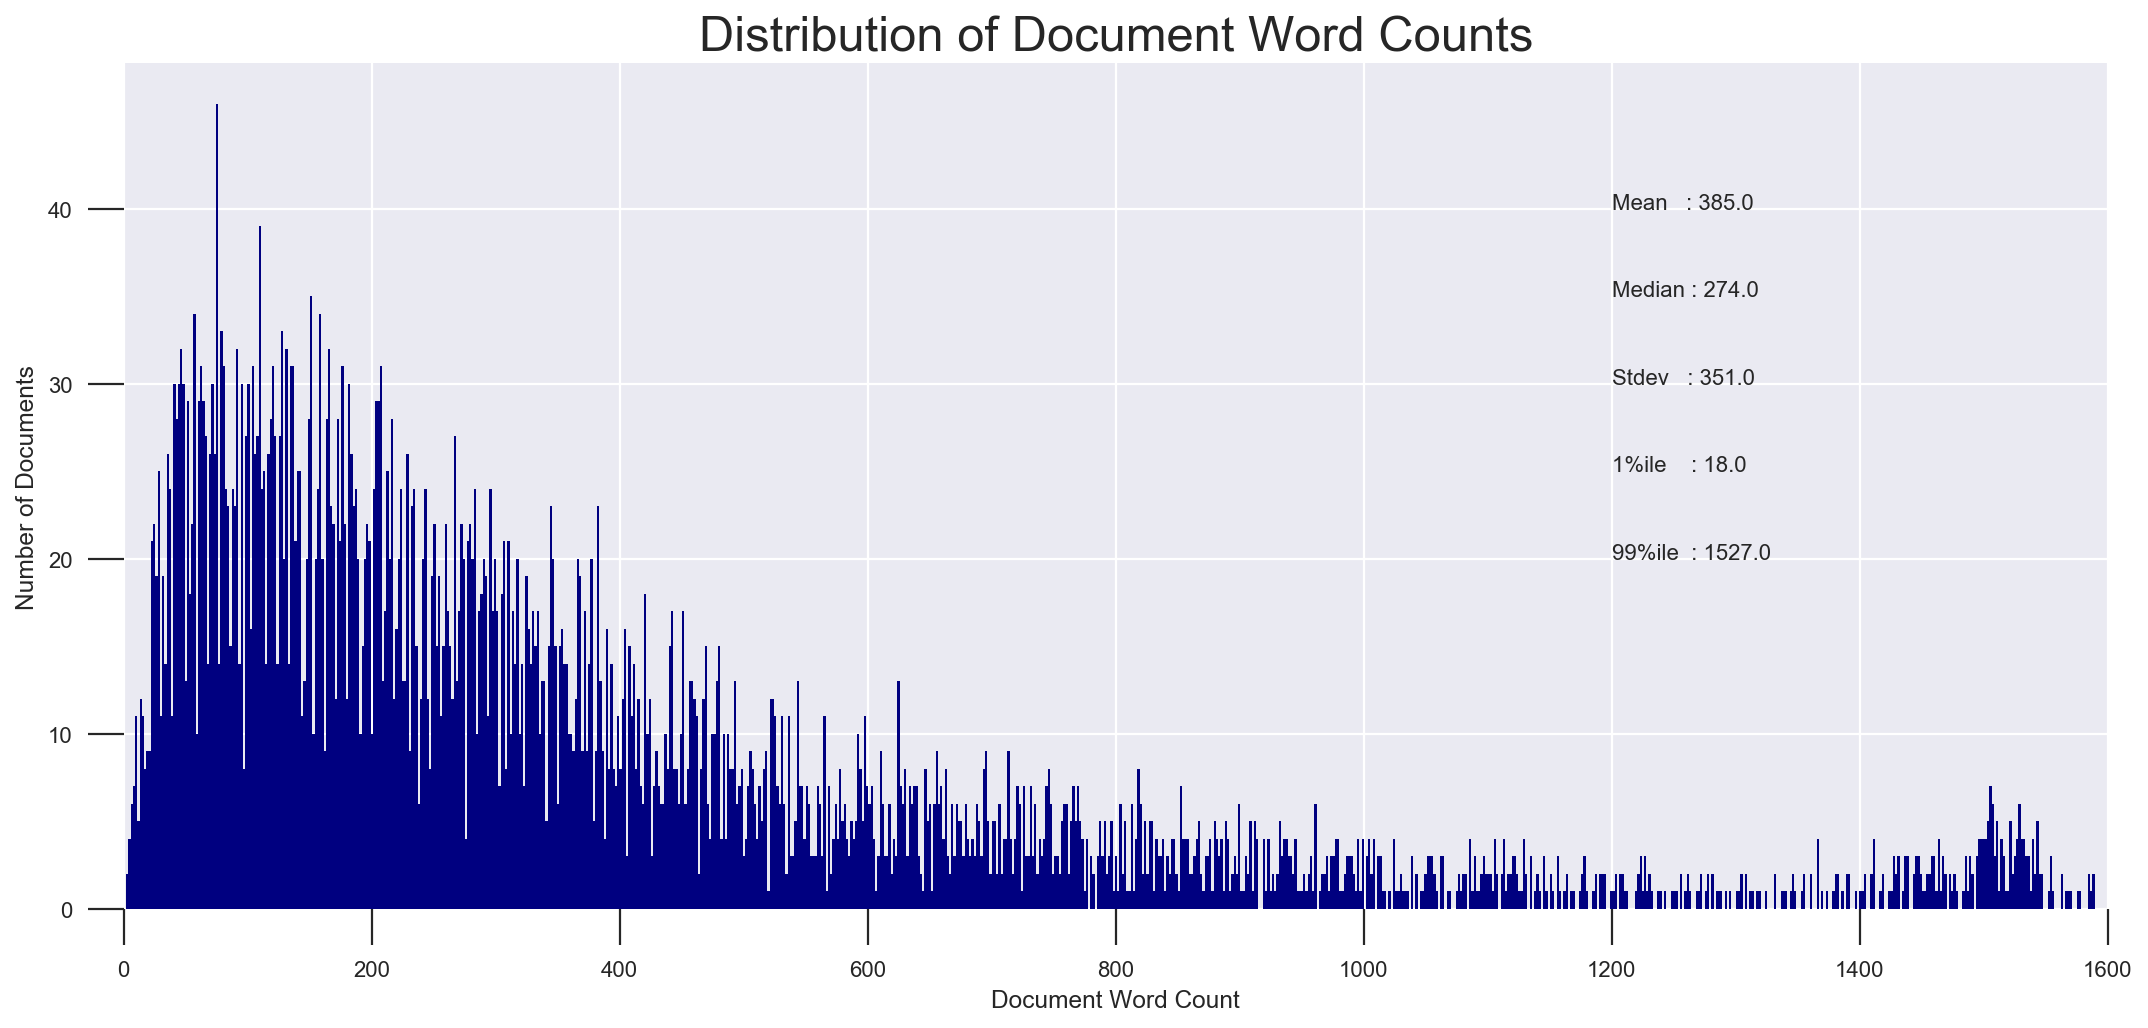

In [23]:
doc_lens = [len(d) for d in df.commentBody]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(1200, 40, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(1200, 35, "Median : " + str(round(np.median(doc_lens))))
plt.text(1200, 30, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(1200, 25, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(1200, 20, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1600), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1600,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.savefig('distrib_wc_before.png', dpi = 160)
plt.show()

#### Loading the data

In [20]:
# hyperparameters
k = 15
stemming_ = True 
p_ = 1
n_word_keep_ = 20

# dataloading
data = load_data(df, embed_path_300, stemming = stemming_, K = k, p = p_, n_word_keep = n_word_keep_, balance = False)

100% (400000 of 400000) |################| Elapsed Time: 0:00:32 Time:  0:00:32


extraction done in 39.828s.
stemming
The vocabulary has been reduced from 23088 words to 6648 words. This represents a reduction of 71.21 percent
computing LDA
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 2

#### Heuristics on the documents after stemming


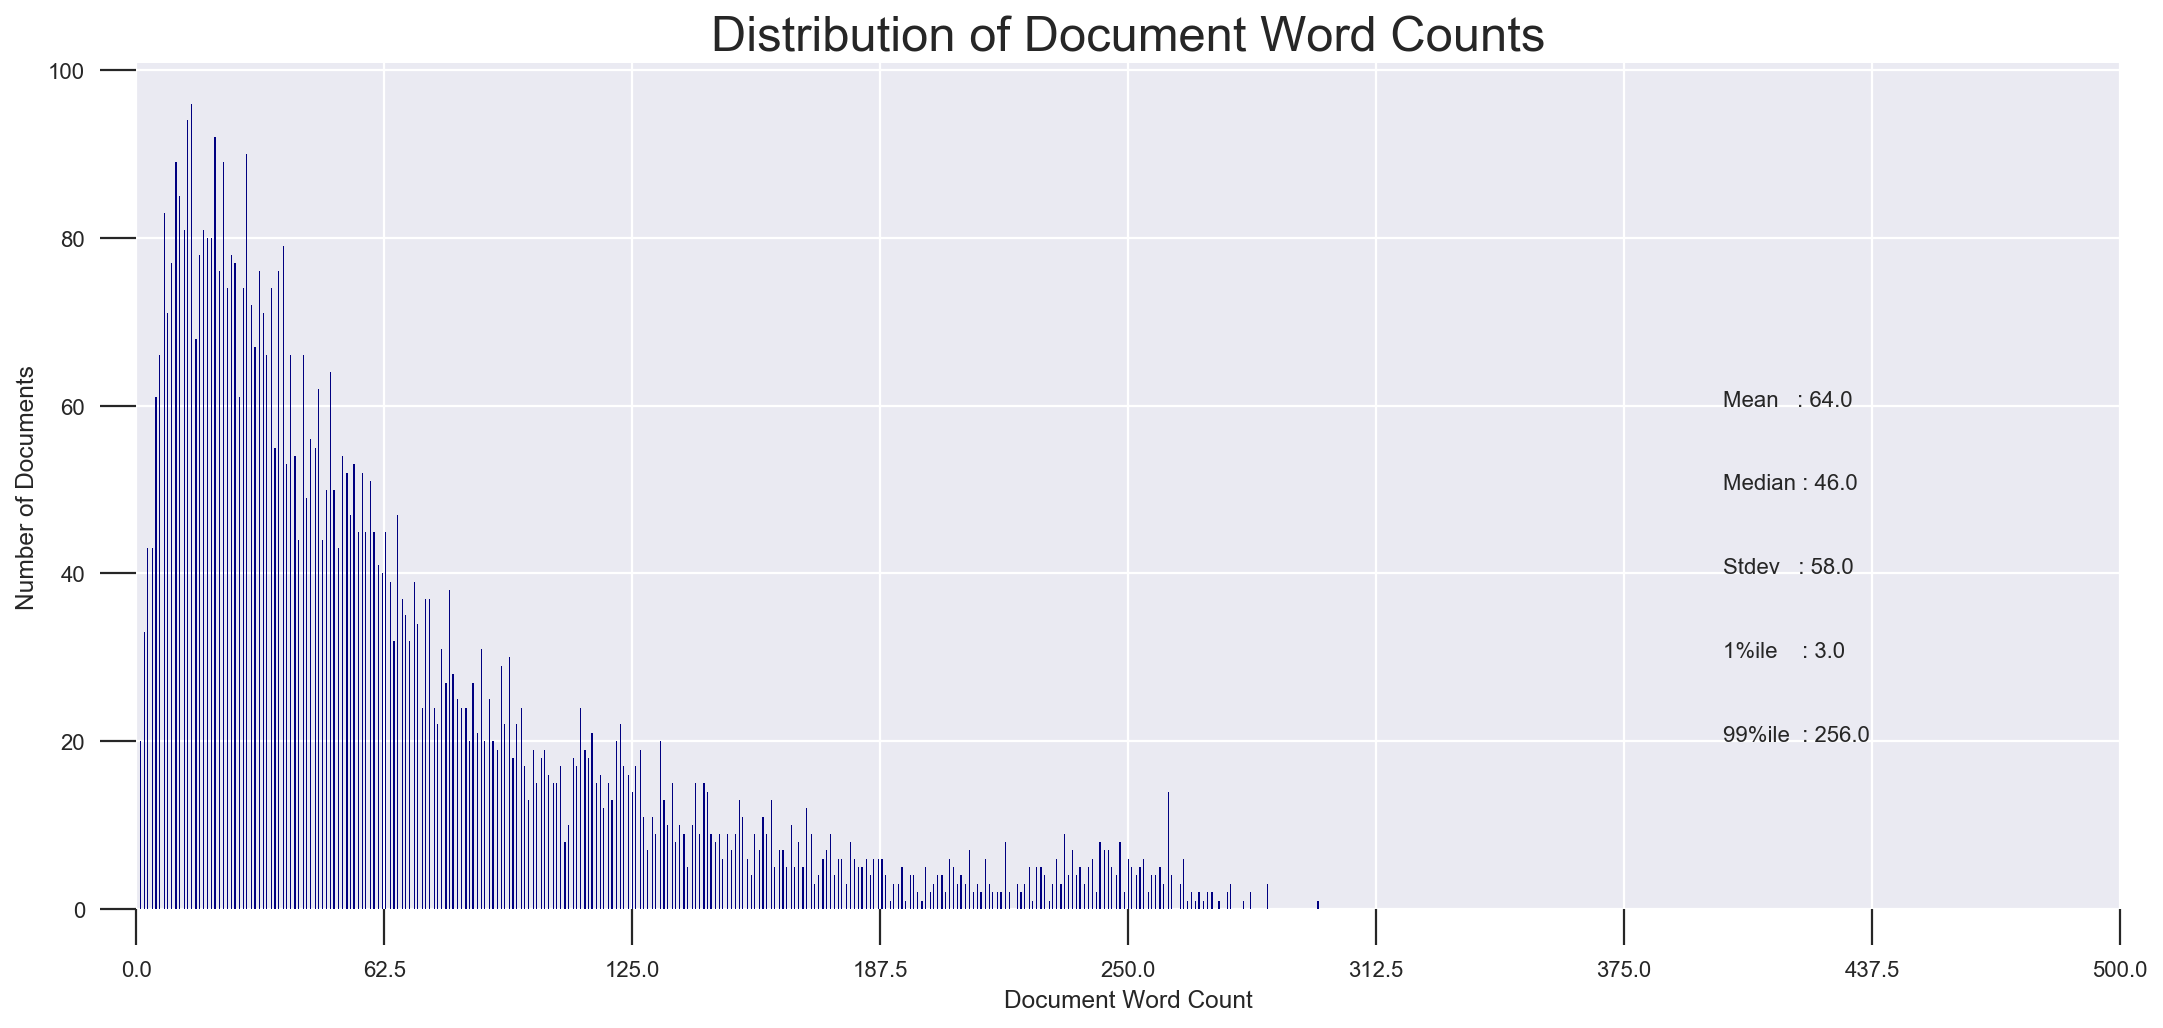

In [22]:
doc_lens = [len(d) for d in data['text']]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(400, 60, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(400,  50, "Median : " + str(round(np.median(doc_lens))))
plt.text(400,  40, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(400,  30, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(400,  20, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 500), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,500,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.savefig('distrib_wc_after.png', dpi = 160)
plt.show()

In [25]:
voc, y = transform_dataframe(df)
sent_topics_df = pd.DataFrame()
for i, row_list in enumerate(data['proportions']):
    max_proportion = np.amax(row_list)
    idx_max_topic = np.where(row_list == max_proportion)[0][0]
    sent_topics_df = sent_topics_df.append(pd.Series([int(idx_max_topic), round(max_proportion,4), data['topic_words'][idx_max_topic]]), ignore_index=True)

sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
sent_topics_df["Text"] = voc
del voc, y

sent_topics_df.head(10)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,4.0,0.2145,"[think, could, interest, mayb, someth, idea, m...","[when, adm, jackson, gave, his, press, confere..."
1,14.0,0.1212,"[women, peopl, white, mani, men, articl, would...","[but, why, was, this, man, white, house, physi..."
2,0.0,0.1489,"[school, work, pay, job, money, educ, public, ...","[stop, at, the, second, paragraph, he, drank, ..."
3,6.0,0.1131,"[use, everi, seem, look, peopl, two, like, hum...","[this, shouldnt, surprise, anyone, given, the,..."
4,3.0,0.1256,"[need, much, food, world, import, car, market,...","[everyone, trump, touches, is, forever, soiled..."
5,0.0,0.1987,"[school, work, pay, job, money, educ, public, ...","[an, overweight, out, of, shape, guy, in, a, t..."
6,13.0,0.3002,"[trump, state, republican, vote, democrat, lik...","[i, am, not, a, socialscientist, but, this, so..."
7,11.0,0.1545,"[countri, trump, presid, war, american, nation...","[i, continue, to, be, amazed, and, quietly, en..."
8,14.0,0.1705,"[women, peopl, white, mani, men, articl, would...","[this, is, something, i, figured, out, in, 201..."
9,11.0,0.1520,"[countri, trump, presid, war, american, nation...","[the, fear, of, loss, of, us, global, dominanc..."


#### Most representative sentence of each topic

In [26]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = sent_topics_df.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.6448,"[school, work, pay, job, money, educ, public, ...","[the, most, common, contemporary, discussion, ..."
1,1.0,0.4452,"[may, hope, believ, keep, without, real, big, ...","[australia, brunei, darussalam, malaysia, peru..."
2,2.0,0.5137,"[dont, want, new, never, get, first, way, didn...","[deb, i, like, theme, first, then, tricky, clu..."
3,3.0,0.7108,"[need, much, food, world, import, car, market,...","[the, most, obvious, is, the, removal, of, the..."
4,4.0,0.5425,"[think, could, interest, mayb, someth, idea, m...","[the, school, definitely, did, not, handle, th..."
5,5.0,0.4792,"[good, like, feel, thank, stori, made, read, w...","[thank, you, maggie, for, sharing, your, story..."
6,6.0,0.5965,"[use, everi, seem, look, peopl, two, like, hum...","[the, mind, this, judgmental, mind, will, neve..."
7,7.0,0.3581,"[know, time, still, realli, go, cant, alway, h...","[first, caitlin, thank, you, for, ãââhave, you..."
8,8.0,0.6618,"[parent, life, take, mani, need, live, childre...","[i, am, a, man, who, graduated, from, antioch,..."
9,9.0,0.5632,"[thing, noth, music, like, ever, set, away, su...","[when, music, meant, soaring, melody, and, lyr..."


#### Distribution of words per documents per LDA Topic

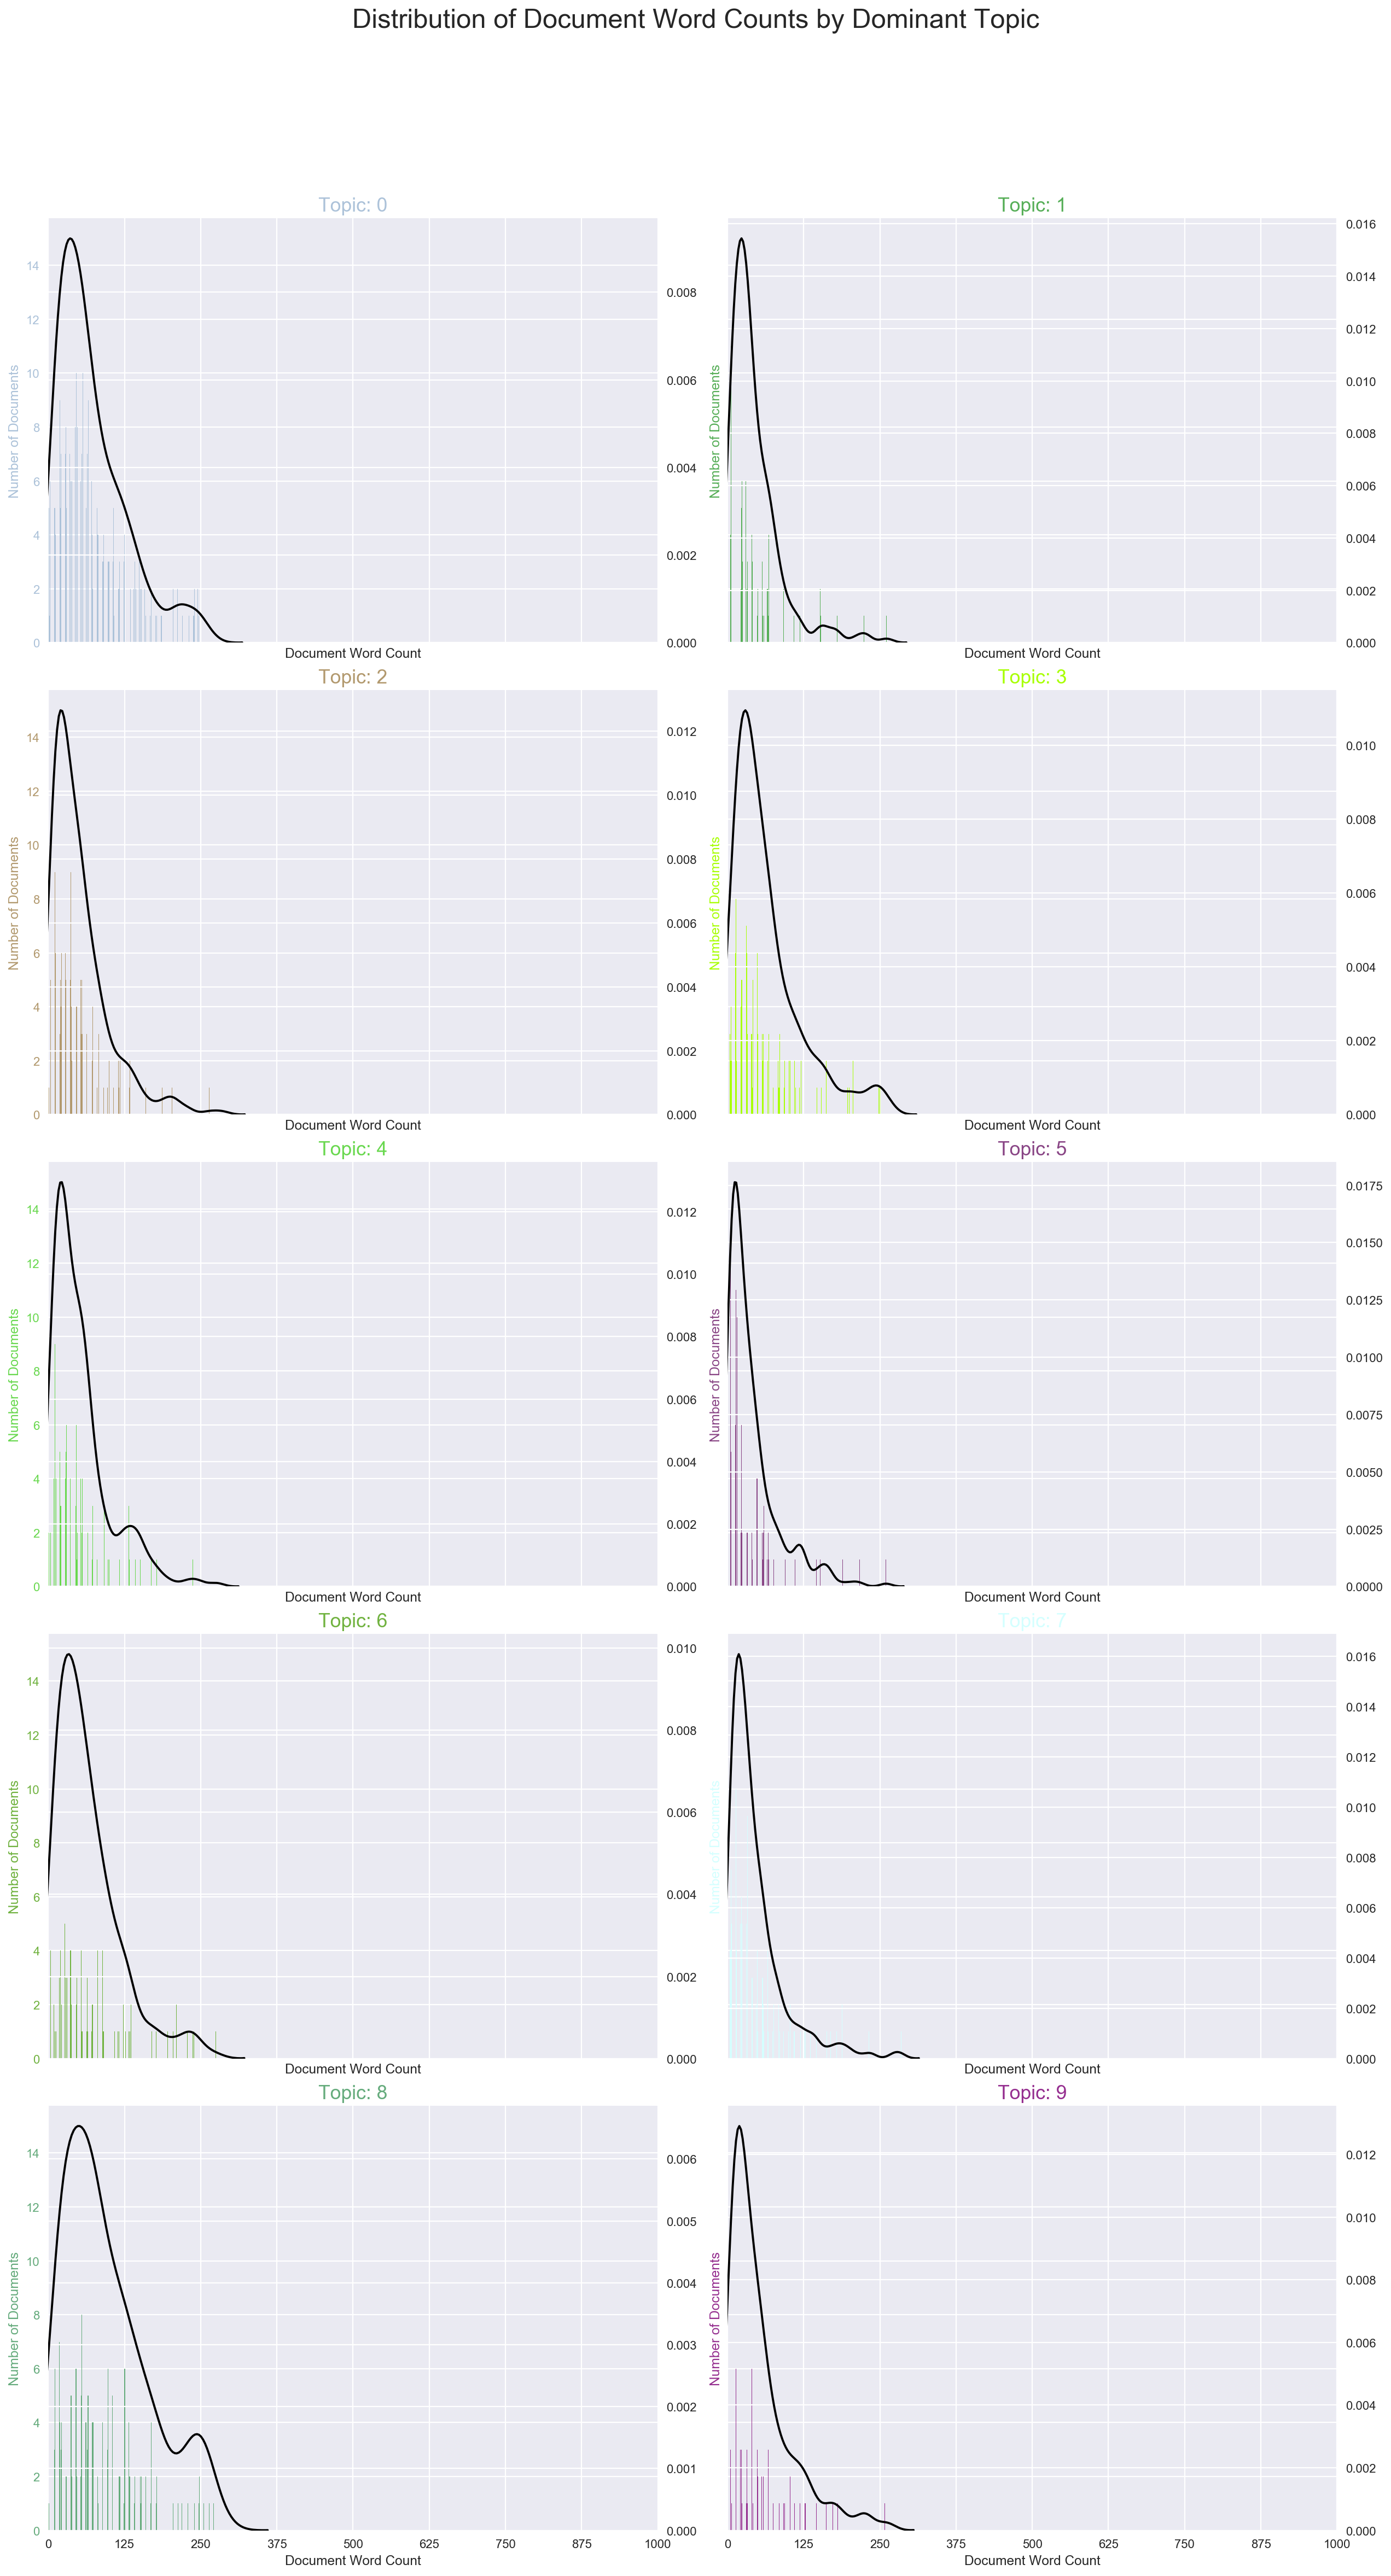

In [27]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(5,2,figsize=(16,30), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = sent_topics_df.loc[sent_topics_df.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub['Text']]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.savefig('word_distrib_topics.png')
plt.show()

In [6]:
bow_train, bow_test, topic_train, topic_test, y_train, y_test = train_test_split(data['X'],
                                                                                 data['proportions'],
                                                                                 data['y'],
                                                                                 random_state= 0)
y_train = y_train.ravel()
y_test = y_test.ravel()
C = data['cost_T']

### Parameter Tuning

In [15]:
K = {10,15,20,25,30,35,40,45,50,55,60,65,70}
test_error_ = dict()

for k in K:

    # dataloading
    data = load_data(df, embed_path_300, stemming = stemming_, K = k, p = p_, n_word_keep = n_word_keep_, balance = False)
    bow_train, bow_test, topic_train, topic_test, y_train, y_test = train_test_split(data['X'],
                                                                                 data['proportions'],
                                                                                 data['y'],
                                                                                 random_state= 0)
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    C = data['cost_T']
       
    
    test_error = dict()
    for neigh in np.arange(7, 22, 2):
        hott_test_error, hott_pred = knn(topic_train, topic_test, y_train, y_test, hott, C, n_neighbors=neigh)
        test_error[neigh] = hott_test_error
        print('Pour un %s topics et un nombre de voisin égal à %s l\'erreur sur la base de test est de l\'ordre de %s'%(k,neigh,hott_test_error))
    test_error_[k] = test_error

100% (400000 of 400000) |################| Elapsed Time: 0:00:38 Time:  0:00:38


extraction done in 46.444s.
stemming
The vocabulary has been reduced from 23088 words to 6648 words. This represents a reduction of 71.21 percent
computing LDA
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 2

LDA fit done in 296.930s.
computing distance
computing optimal transport calculation
843.0664792060852
Pour un 65 topics et un nombre de voisin égal à 7 l'erreur sur la base de test est de l'ordre de 0.8761118170266836
838.3338460922241
Pour un 65 topics et un nombre de voisin égal à 9 l'erreur sur la base de test est de l'ordre de 0.8831003811944091
826.0980849266052
Pour un 65 topics et un nombre de voisin égal à 11 l'erreur sur la base de test est de l'ordre de 0.8888182973316392
890.1559019088745
Pour un 65 topics et un nombre de voisin égal à 13 l'erreur sur la base de test est de l'ordre de 0.8907242693773825
818.664098739624
Pour un 65 topics et un nombre de voisin égal à 15 l'erreur sur la base de test est de l'ordre de 0.8881829733163914
807.0632882118225
Pour un 65 topics et un nombre de voisin égal à 17 l'erreur sur la base de test est de l'ordre de 0.8900889453621347
879.2636098861694
Pour un 65 topics et un nombre de voisin égal à 19 l'erreur sur la base de test est de l'o

100% (400000 of 400000) |################| Elapsed Time: 0:00:39 Time:  0:00:39


extraction done in 48.181s.
stemming
The vocabulary has been reduced from 23088 words to 6648 words. This represents a reduction of 71.21 percent
computing LDA
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 2

749.6047899723053
Pour un 35 topics et un nombre de voisin égal à 13 l'erreur sur la base de test est de l'ordre de 0.8742058449809402
773.2619938850403
Pour un 35 topics et un nombre de voisin égal à 15 l'erreur sur la base de test est de l'ordre de 0.8792884371029225
736.665354013443
Pour un 35 topics et un nombre de voisin égal à 17 l'erreur sur la base de test est de l'ordre de 0.8805590851334181
746.4882290363312
Pour un 35 topics et un nombre de voisin égal à 19 l'erreur sur la base de test est de l'ordre de 0.8805590851334181
811.3428683280945
Pour un 35 topics et un nombre de voisin égal à 21 l'erreur sur la base de test est de l'ordre de 0.8856416772554002


100% (400000 of 400000) |################| Elapsed Time: 0:00:47 Time:  0:00:47


extraction done in 58.504s.
stemming
The vocabulary has been reduced from 23088 words to 6648 words. This represents a reduction of 71.21 percent
computing LDA
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 2

LDA fit done in 367.092s.
computing distance
computing optimal transport calculation
1009.370747089386
Pour un 70 topics et un nombre de voisin égal à 7 l'erreur sur la base de test est de l'ordre de 0.8926302414231257
1001.249153137207
Pour un 70 topics et un nombre de voisin égal à 9 l'erreur sur la base de test est de l'ordre de 0.8843710292249047
872.3376889228821
Pour un 70 topics et un nombre de voisin égal à 11 l'erreur sur la base de test est de l'ordre de 0.8881829733163914
833.5478897094727
Pour un 70 topics et un nombre de voisin égal à 13 l'erreur sur la base de test est de l'ordre de 0.8983481575603558
831.2289509773254
Pour un 70 topics et un nombre de voisin égal à 15 l'erreur sur la base de test est de l'ordre de 0.9027954256670903
834.5912148952484
Pour un 70 topics et un nombre de voisin égal à 17 l'erreur sur la base de test est de l'ordre de 0.8926302414231257
833.5706970691681
Pour un 70 topics et un nombre de voisin égal à 19 l'erreur sur la base de test est de l'

100% (400000 of 400000) |################| Elapsed Time: 0:00:30 Time:  0:00:30


extraction done in 37.465s.
stemming
The vocabulary has been reduced from 23088 words to 6648 words. This represents a reduction of 71.21 percent
computing LDA
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 2

LDA fit done in 218.619s.
computing distance
computing optimal transport calculation
630.0878007411957
Pour un 40 topics et un nombre de voisin égal à 7 l'erreur sur la base de test est de l'ordre de 0.8697585768742059
630.532476902008
Pour un 40 topics et un nombre de voisin égal à 9 l'erreur sur la base de test est de l'ordre de 0.8678526048284625
630.2961483001709
Pour un 40 topics et un nombre de voisin égal à 11 l'erreur sur la base de test est de l'ordre de 0.8678526048284625
633.7280666828156
Pour un 40 topics et un nombre de voisin égal à 13 l'erreur sur la base de test est de l'ordre de 0.874841168996188
631.1529998779297
Pour un 40 topics et un nombre de voisin égal à 15 l'erreur sur la base de test est de l'ordre de 0.8805590851334181
632.1306040287018
Pour un 40 topics et un nombre de voisin égal à 17 l'erreur sur la base de test est de l'ordre de 0.8805590851334181
631.9018161296844
Pour un 40 topics et un nombre de voisin égal à 19 l'erreur sur la base de test est de l'or

100% (400000 of 400000) |################| Elapsed Time: 0:00:32 Time:  0:00:32


extraction done in 38.786s.
stemming
The vocabulary has been reduced from 23088 words to 6648 words. This represents a reduction of 71.21 percent
computing LDA
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 2

100% (400000 of 400000) |################| Elapsed Time: 0:00:31 Time:  0:00:31


extraction done in 37.971s.
stemming
The vocabulary has been reduced from 23088 words to 6648 words. This represents a reduction of 71.21 percent
computing LDA
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 2

LDA fit done in 225.912s.
computing distance
computing optimal transport calculation
670.8259751796722
Pour un 45 topics et un nombre de voisin égal à 7 l'erreur sur la base de test est de l'ordre de 0.8831003811944091
669.7875111103058
Pour un 45 topics et un nombre de voisin égal à 9 l'erreur sur la base de test est de l'ordre de 0.886277001270648
669.4032440185547
Pour un 45 topics et un nombre de voisin égal à 11 l'erreur sur la base de test est de l'ordre de 0.8869123252858958
671.5328929424286
Pour un 45 topics et un nombre de voisin égal à 13 l'erreur sur la base de test est de l'ordre de 0.8900889453621347
669.265790939331
Pour un 45 topics et un nombre de voisin égal à 15 l'erreur sur la base de test est de l'ordre de 0.8894536213468869
669.8734741210938
Pour un 45 topics et un nombre de voisin égal à 17 l'erreur sur la base de test est de l'ordre de 0.8926302414231257
668.9455029964447
Pour un 45 topics et un nombre de voisin égal à 19 l'erreur sur la base de test est de l'or

100% (400000 of 400000) |################| Elapsed Time: 0:00:30 Time:  0:00:30


extraction done in 36.799s.
stemming
The vocabulary has been reduced from 23088 words to 6648 words. This represents a reduction of 71.21 percent
computing LDA
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 2

100% (400000 of 400000) |################| Elapsed Time: 0:00:31 Time:  0:00:31


extraction done in 38.198s.
stemming
The vocabulary has been reduced from 23088 words to 6648 words. This represents a reduction of 71.21 percent
computing LDA
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 2

LDA fit done in 236.118s.
computing distance
computing optimal transport calculation
703.4595639705658
Pour un 50 topics et un nombre de voisin égal à 7 l'erreur sur la base de test est de l'ordre de 0.8888182973316392
701.303915977478
Pour un 50 topics et un nombre de voisin égal à 9 l'erreur sur la base de test est de l'ordre de 0.8958068614993646
701.9198410511017
Pour un 50 topics et un nombre de voisin égal à 11 l'erreur sur la base de test est de l'ordre de 0.8939008894536213
701.7789731025696
Pour un 50 topics et un nombre de voisin égal à 13 l'erreur sur la base de test est de l'ordre de 0.8970775095298602
700.3153891563416
Pour un 50 topics et un nombre de voisin égal à 15 l'erreur sur la base de test est de l'ordre de 0.8939008894536213
701.0630428791046
Pour un 50 topics et un nombre de voisin égal à 17 l'erreur sur la base de test est de l'ordre de 0.8907242693773825
700.4937601089478
Pour un 50 topics et un nombre de voisin égal à 19 l'erreur sur la base de test est de l'o

100% (400000 of 400000) |################| Elapsed Time: 0:00:31 Time:  0:00:31


extraction done in 37.507s.
stemming
The vocabulary has been reduced from 23088 words to 6648 words. This represents a reduction of 71.21 percent
computing LDA
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 2

100% (400000 of 400000) |################| Elapsed Time: 0:00:39 Time:  0:00:39


extraction done in 47.797s.
stemming
The vocabulary has been reduced from 23088 words to 6648 words. This represents a reduction of 71.21 percent
computing LDA
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 2

LDA fit done in 284.682s.
computing distance
computing optimal transport calculation
812.5109288692474
Pour un 55 topics et un nombre de voisin égal à 7 l'erreur sur la base de test est de l'ordre de 0.8837357052096569
925.1746461391449
Pour un 55 topics et un nombre de voisin égal à 9 l'erreur sur la base de test est de l'ordre de 0.8869123252858958
865.0739781856537
Pour un 55 topics et un nombre de voisin égal à 11 l'erreur sur la base de test est de l'ordre de 0.8856416772554002
842.3764328956604
Pour un 55 topics et un nombre de voisin égal à 13 l'erreur sur la base de test est de l'ordre de 0.8875476493011436
897.8772170543671
Pour un 55 topics et un nombre de voisin égal à 15 l'erreur sur la base de test est de l'ordre de 0.8894536213468869
965.9888217449188
Pour un 55 topics et un nombre de voisin égal à 17 l'erreur sur la base de test est de l'ordre de 0.8932655654383735
922.647775888443
Pour un 55 topics et un nombre de voisin égal à 19 l'erreur sur la base de test est de l'o

100% (400000 of 400000) |################| Elapsed Time: 0:00:33 Time:  0:00:33


extraction done in 40.449s.
stemming
The vocabulary has been reduced from 23088 words to 6648 words. This represents a reduction of 71.21 percent
computing LDA
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 2

100% (400000 of 400000) |################| Elapsed Time: 0:00:35 Time:  0:00:35


extraction done in 42.308s.
stemming
The vocabulary has been reduced from 23088 words to 6648 words. This represents a reduction of 71.21 percent
computing LDA
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 2

LDA fit done in 274.864s.
computing distance
computing optimal transport calculation
772.2019152641296
Pour un 60 topics et un nombre de voisin égal à 7 l'erreur sur la base de test est de l'ordre de 0.8881829733163914
815.2854897975922
Pour un 60 topics et un nombre de voisin égal à 9 l'erreur sur la base de test est de l'ordre de 0.8850063532401524
775.178328037262
Pour un 60 topics et un nombre de voisin égal à 11 l'erreur sur la base de test est de l'ordre de 0.8888182973316392
764.7235400676727
Pour un 60 topics et un nombre de voisin égal à 13 l'erreur sur la base de test est de l'ordre de 0.8932655654383735
765.0575828552246
Pour un 60 topics et un nombre de voisin égal à 15 l'erreur sur la base de test est de l'ordre de 0.8932655654383735
886.0140438079834
Pour un 60 topics et un nombre de voisin égal à 17 l'erreur sur la base de test est de l'ordre de 0.8970775095298602
935.5053572654724
Pour un 60 topics et un nombre de voisin égal à 19 l'erreur sur la base de test est de l'o

100% (400000 of 400000) |################| Elapsed Time: 0:00:41 Time:  0:00:41


extraction done in 49.921s.
stemming
The vocabulary has been reduced from 23088 words to 6648 words. This represents a reduction of 71.21 percent
computing LDA
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 2

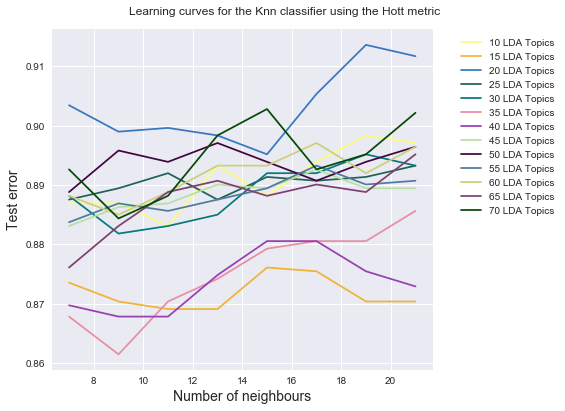

In [19]:
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.XKCD_COLORS.items()] 

plt.style.use('seaborn')
for k in [10,15,20,25,30,35,40,45,50,55,60,65,70] :
    
    plt.plot(test_error_[k].keys(), test_error_[k].values(), label = str(k)+' LDA Topics', c = cols[k])

plt.ylabel('Test error', fontsize = 14)
#plt.axvline(x=11, linewidth=0.5, color='r')
plt.xlabel('Number of neighbours', fontsize = 14)
plt.suptitle('Learning curves for the Knn classifier using the Hott metric', fontsize = 12, y = 1.03)
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.savefig('test_error_paramtuning.png', dpi = 160)

##### It seems that the best choice is 35 LDA topics and k = 7. However, the optimal choice for interpretation seems to be 15 LDA topics and 13 neighbours.

### T-SNE Representation

In [28]:
def cust_hott(p,q):
    
    return hott(p, q, C, threshold=None)

In [29]:
D = {}

for id1,doc1 in enumerate(data['proportions']):
    D[id1] = {}
    for id2,doc2 in enumerate(data['proportions']):
        D[id1][id2] = hott(doc1, doc2, C, threshold=None)
        
hott_mat = pd.DataFrame.from_dict(D)

In [30]:
import seaborn as sns
import matplotlib.colors as mcolors

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

cols = [color for name, color in mcolors.XKCD_COLORS.items()] 
colors = {}
for y_ in np.unique(data['y']) :
    colors[y_] = cols[y_+3]

In [31]:
from sklearn.manifold import TSNE 

Xtsne = pd.DataFrame(TSNE(n_components=2, metric = cust_hott).fit_transform(data['proportions']), columns = ['col1','col2'])
Xtsne['hue_'] = data['y']

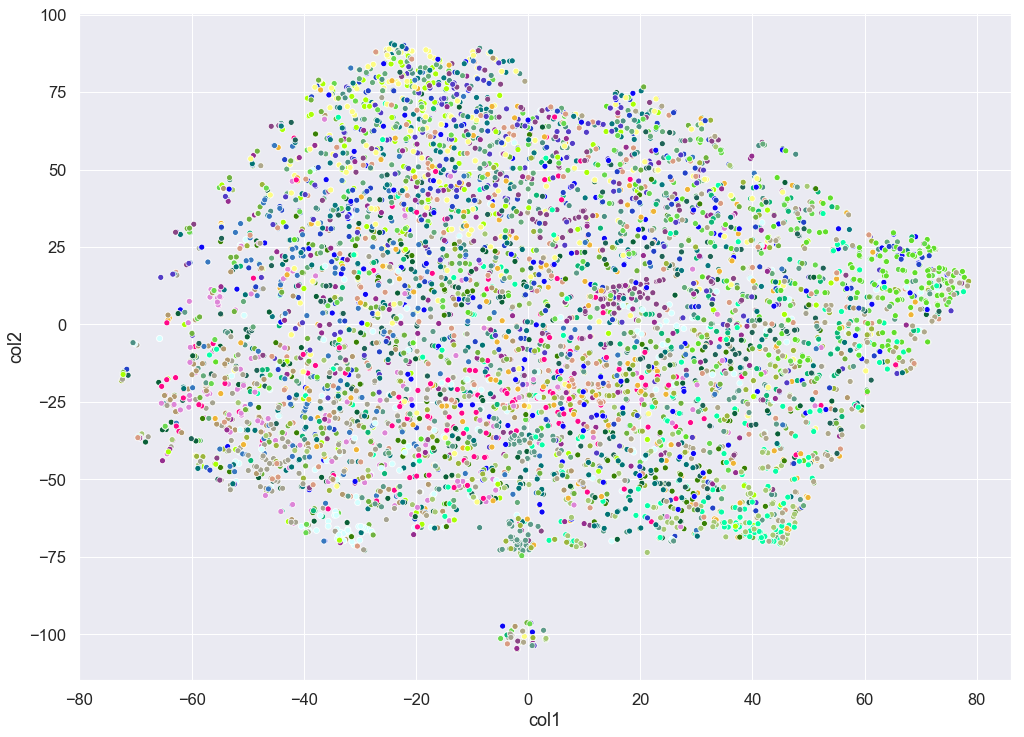

In [33]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(16.7, 12.27)
sns_plot = sns.scatterplot('col1','col2', data = Xtsne, hue = 'hue_', palette = colors, legend = False)
fig_ = sns_plot.get_figure()
fig_.savefig("tsne.png")